<a href="https://colab.research.google.com/github/Rominaalena/disd_python-datascience-intro/blob/master/Final_Python_Code_07_04_25_Line_Chart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Detailed Data Output:
                              value  sensorsId  locationsId  \
datetime.utc                                                  
2025-04-08 09:00:00+00:00   19.0000    8539597      2622686   
2025-04-08 08:00:00+00:00   -1.0000      23735         8152   
2021-08-09 11:00:00+00:00   16.0000     238048        43487   
2025-01-12 15:00:00+00:00   11.0000    7320157      1772963   
2024-12-09 12:00:00+00:00    6.0000    7754909      2146563   
...                             ...        ...          ...   
2021-08-09 11:00:00+00:00   22.0000     237788        43622   
2024-01-29 19:00:00+00:00   19.5559      13413         5185   
2025-01-28 16:00:00+00:00  100.0840       6307         2976   
2025-04-08 08:00:00+00:00   16.2000      24713         8503   
2025-04-08 08:00:00+00:00   28.0000      24398         8401   

                                      datetime.local  coordinates.latitude  \
datetime.utc                                                                 
2

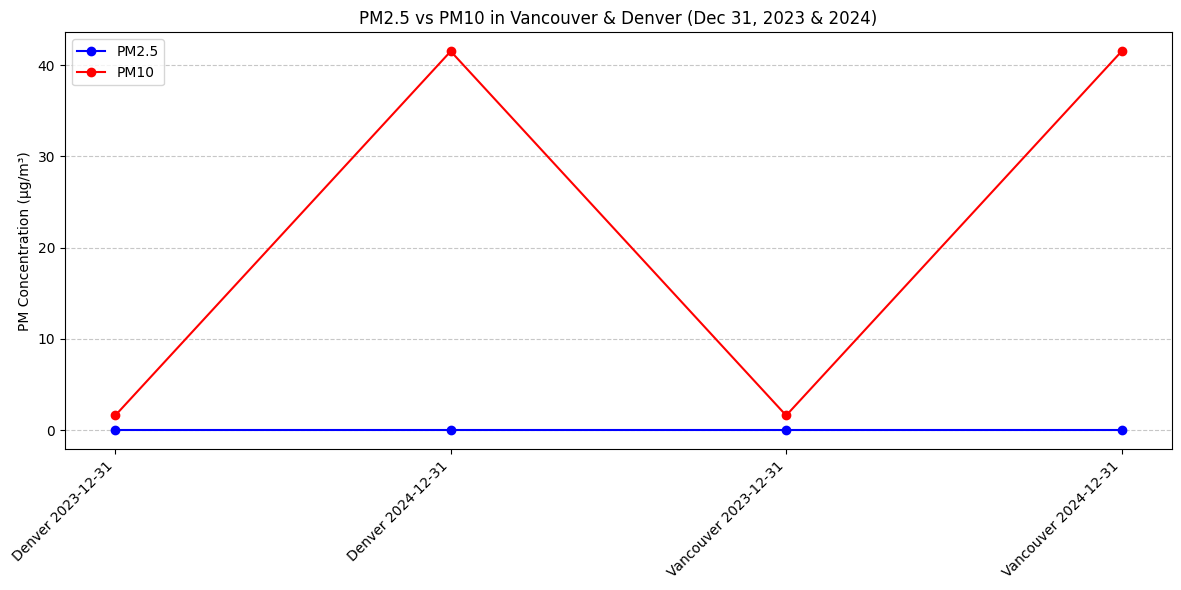

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# API Key
api_key = "e0cd22528d1f3a51cee6cebb84eeb5ffa29eb5961e186aa30ec6401d06aeecf7"

# API URLs for PM2.5 (id=2) and PM10 (id=5) for Vancouver and Denver
url_template = (
    "https://api.openaq.org/v3/parameters/{param_id}/latest?"
    "bbox={bbox}&limit=1000"
)

headers = {
    "X-API-Key": api_key,
    "Accept": "application/json"
}

# Define bounding boxes
bbox_vancouver = "-123.26,49.00,-122.42,49.37"
bbox_denver = "-105.11,39.60,-104.60,39.92"

# Enhanced function to fetch and extract measurement data with more details
def fetch_air_quality_data(param_id, city_name, bbox):
    url = url_template.format(param_id=param_id, bbox=bbox)
    response = requests.get(url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch data for {city_name} (Param {param_id})")
        return []

    data = response.json()
    rows = []

    for item in data.get("results", []):
        city = city_name
        location_id = item.get("locationsId")
        sensor_id = item.get("sensorsId")
        value = item.get("value")

        dt_info = item.get("datetime", {})
        date_utc = dt_info.get("utc")
        date_local = dt_info.get("local")

        timestamp_utc = None
        if date_utc:
            try:
                timestamp_utc = datetime.fromisoformat(date_utc.replace("Z", "+00:00"))
            except Exception:
                pass

        # Get coordinates
        coordinates = item.get("coordinates", {})
        latitude = coordinates.get("latitude")
        longitude = coordinates.get("longitude")

        rows.append({
            "city": city,
            "pollutant": "PM2.5" if param_id == 2 else "PM10",
            "value": value,
            "sensorsId": sensor_id,
            "locationsId": location_id,
            "datetime.utc": timestamp_utc,
            "datetime.local": date_local,
            "coordinates.latitude": latitude,
            "coordinates.longitude": longitude
        })

    return rows

# Fetch data for both PM2.5 and PM10
vancouver_pm25 = fetch_air_quality_data(2, "Vancouver", bbox_vancouver)
vancouver_pm10 = fetch_air_quality_data(5, "Vancouver", bbox_vancouver)
denver_pm25 = fetch_air_quality_data(2, "Denver", bbox_denver)
denver_pm10 = fetch_air_quality_data(5, "Denver", bbox_denver)

# Combine data into a single DataFrame
all_data = vancouver_pm25 + vancouver_pm10 + denver_pm25 + denver_pm10
df = pd.DataFrame(all_data)

# Set datetime.utc as index for the detailed table format
if not df.empty and 'datetime.utc' in df.columns:
    df_detailed = df.set_index('datetime.utc')
    print("\nDetailed Data Output:")
    print(df_detailed[['value', 'sensorsId', 'locationsId', 'datetime.local',
                       'coordinates.latitude', 'coordinates.longitude', 'pollutant', 'city']])

# Continue with your existing visualization code
if not df.empty and 'datetime.utc' in df.columns:
    # Convert timestamps and filter for December 31, 2023, and December 31, 2024
    df["date"] = df["datetime.utc"].dt.date
    df_filtered = df[df["date"].isin([datetime(2023, 12, 31).date(), datetime(2024, 12, 31).date()])]

    # Aggregate by city, date, and pollutant (average values if multiple readings)
    df_agg = df_filtered.groupby(["city", "date", "pollutant"])["value"].mean().reset_index()

    # Pivot table to ensure PM2.5 and PM10 are included
    df_pivot = df_agg.pivot(index=["city", "date"], columns="pollutant", values="value").reset_index()

    # Ensure missing PM values are explicitly set to 0
    df_pivot = df_pivot.rename_axis(None, axis=1).fillna(0)

    print("\nFiltered Data for Visualization:")
    print(df_pivot)

    # Plot line chart
fig, ax = plt.subplots(figsize=(12, 6))

# Define labels and data
labels = [f"{row['city']} {row['date']}" for _, row in df_pivot.iterrows()]
pm25_values = df_pivot.get("PM2.5", pd.Series([0]*len(labels)))
pm10_values = df_pivot.get("PM10", pd.Series([0]*len(labels)))

# Plot the lines
ax.plot(labels, pm25_values, marker='o', linestyle='-', color='blue', label='PM2.5')
ax.plot(labels, pm10_values, marker='o', linestyle='-', color='red', label='PM10')

# Formatting
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("PM Concentration (µg/m³)")
ax.set_title("PM2.5 vs PM10 in Vancouver & Denver (Dec 31, 2023 & 2024)")
ax.legend()
ax.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
